In [3]:
## Loading Libraries
import pandas as pd
import numpy as np
import networkx as nx
import random
from random import uniform
import matplotlib.pyplot as plt 
import pickle

In [86]:
## Functions for generating seeds
def generateRandSeed(num,Graph):
    """ A simple function to generate "num" random seeds"""
    return(np.random.choice(list(range(Graph.number_of_nodes())),num,replace=False))

def generateEigSeed(num,Graph):
    """ A simple function to find "num" seeds with highest eigen-vector centrality """
    eig_cen=nx.eigenvector_centrality_numpy(Graph)
    return(list({key: eig_cen[key] for key in sorted(eig_cen, key=eig_cen.get, reverse=True)[:num]}))

def generateDegSeed(num,Graph):
    """ A simple function to find "num" seeds with highest degree centrality """
    deg_cen=nx.degree_centrality(Graph)
    return(list({key: deg_cen[key] for key in sorted(deg_cen, key=deg_cen.get, reverse=True)[:num]}))

# Function dictionary for generating seeds
switch_seed_method = {'Random':generateRandSeed,'Eigen':generateEigSeed,'Degree':generateDegSeed}    

In [77]:
## SIR Simulation
def Simulate_SIR (Graph,c=0.3, numSeed = 20, Repeat=50 , how='Degree'):
    """ A function to run "SIR" model simulation on a Graph 
        
    ...
    Parameters
    ----------
    Graph: networkx.Graph,
        A graph to run the simulation on
        
    c: int, default values is 0.3
        The probabilty of passing information to another node.
        
    numSeed: int, default value is 20
        We check seeds size 1,2,....,numSeed.
        "numseed" must be smaller than graph size
        
    Repeat: int, default value is 50
        Number of repeats.
    
    how: str, default value is "Degree"
        The method to generate seeds.
        It must be one of the ['Degree','Random','Eigen']
    """
    
    # Size of Graph
    lng = Graph.number_of_nodes()
    
    # Declaring the list of cascade size for each seedsize
    Cascade_size =[]
        
    # Creating Neighbor List
    Neighbors_List = []
    Nodes = list(Graph.nodes())
    Nodes.sort(reverse=False)
    # Finding Neighbors of each node
    for node in list(Nodes):
        Neighbors_List.append(list(dict(Graph.adj[node])))
        
    # If the seeding method is either Degree or Eigen, we only need...
    #... find all the numSeed central nodes, and then pick sizeS first of it
    if how=='Degree' or how=='Eigen':
        SPSeeds = switch_seed_method[how](numSeed,Graph)
   
    # for each seed size
    for sizeS in list(np.arange(1,numSeed+1,1)):
        
        # Cascade size in each repeat
        Cascade_size_rpt =[]
        
        # Repeating the procee
        for rpt in range(Repeat):
            
            # Generating Seeds
            if how=='Random':
                Seeds = switch_seed_method[how](sizeS,Graph)
            else:
                Seeds = SPSeeds[:sizeS]

            # Initializing the Status Lists of Normal and Informed Nodes
            Normal = list(range(lng))
            Informed = list()

            # Adding initial seeds to Informed list
            Informed = [x for x in Seeds]

            # Removing Informeds from Normal list
            Normal = [x for x in Normal if x not in Informed]

            # For each Informed node we try to find the transmissions
            for node in Informed:
                
                ## Finding the Neighbors of the node based which are not informed already
                Neighbors = [k for k in Neighbors_List[node] if k in Normal]
               
                # for each uninformed neighbor
                for advicee in Neighbors:
                    
                    # it Gets information with probability 'c'
                    if  uniform(0,1)<c:
                        Normal.remove(advicee)
                        Informed.append(advicee)
            
            # At the end each repeat (when all informed nodes have a chance to talk to their neighbors),...
            # ... we store the cascade size
            Cascade_size_rpt.append(len(Informed))

        # Calculating average over all repeats, and deviding by size of graph to calculate the percentage
        Cascade_size.append(np.mean(Cascade_size_rpt)/lng)
    
    # Returning a dataframe of Seedsize and average cascade size
    return(pd.DataFrame(data={'SeedSize':list(np.arange(1,numSeed+1,1)),'Cascade':Cascade_size}))

In [89]:
## Threshold Simulation
def Simulate_Thr (Graph,Thr=[uniform(0,1) for x in range(100)], numSeed = 20, Repeat=50 ,how='Degree'):
    """ A function to run "Threshold" model simulation on a Graph 
    
    ...
    Parameters
    ----------
    Graph: networkx.Graph,
        A graph to run the simulation on
        
    Thr: list, default values in uniformly random numbers between 0 and 1
        A list of nodes thresholds
        
    numSeed: int, default value is 20
        We check seeds size 1,2,....,numSeed.
        "numseed" must be smaller than graph size
        
    Repeat: int, default value is 50
        Number of repeats.
    
    how: str, default value is "Degree"
        The method to generate seeds.
        It must be one of the ['Degree','Random','Eigen']
    """
    # Size of Graph
    lng = Graph.number_of_nodes()
    
    # Declaring the list of cascade size for each seedsize
    Cascade_size =[]
        
    # Creating Neighbor List
    Neighbors_List = []
    Nodes = list(Graph.nodes())
    Nodes.sort(reverse=False)
    # Finding Neighbors of each node
    for node in list(Nodes):
        Neighbors_List.append(list(dict(Graph.adj[node])))
        
    # If the seeding method is either Degree or Eigen, we only need...
    #... find all the numSeed central nodes, and then pick sizeS first of it    
    if how=='Degree' or how=='Eigen':
        SPSeeds = switch_seed_method[how](numSeed,Graph)

    # for each seed size
    for sizeS in list(np.arange(1,numSeed+1,1)):
        
        # Cascade size in each repeat
        Cascade_size_rpt =[]
        
        # Repeating the procee
        for rpt in range(Repeat):
            
            # Shuffling the Thresholds (Node have different thresholds in diffrent repeatitions)
            random.shuffle(Thr)
           
            # Generating Seeds
            if how=='Random':
                Seeds = switch_seed_method[how](sizeS,Graph)
            else:
                Seeds = SPSeeds[:sizeS]

            # Initializing the Status Lists of Normal and Informed Nodes  
            Normal = list(range(lng))
            Informed = list()
            New_Informed = []

            # Adding initial seeds to Informed list
            Informed = [x for x in Seeds]

            # Removing Informeds from Normal list
            Normal = [x for x in Normal if x not in Informed]
            
            # We iterate through nodes and find the nodes that fraction of their informed neighbors...
            # ... exceed their threshold. When we converge to the fixed point (size of informed stays constant),...
            # ... we break the loop.
            while True:
                
                # We set the Informed_last_size before starting to find new informeds
                Informed_last_size = len(Informed)
                
                # For nomal nodes
                for node in Normal:

                    # Finding informed Neighbors of the node
                    Informed_Neighbors = [k for k in Neighbors_List[node] if k in Informed]
 
                    # Calculating the fraction of neighbors which are informed
                    try:
                        thr = len(Informed_Neighbors)/len(Neighbors_List[node])
                    except:
                        thr = 0

                    if  thr>Thr[node]:
                        Informed.append(node)
                
                # Removind nodes that are informed from the Normal set
                Normal = [x for x in Normal if x not in Informed]
                
                # If there is no new Informed or all nodes are informed, we break the loop.
                if len(Informed)==Informed_last_size or len(Informed)==lng:
                    break
            
            # At the end each repeat (when all informed nodes have a chance to talk to their neighbors),...
            # ... we store the cascade size        
            Cascade_size_rpt.append(len(Informed))

        # Calculating average over all repeats, and deviding by size of graph to calculate the percentage
        Cascade_size.append(np.mean(Cascade_size_rpt)/lng)  
    
    # Returning a dataframe of Seedsize and average cascade size
    return(pd.DataFrame(data={'SeedSize':list(np.arange(1,numSeed+1,1)),'Cascade':Cascade_size}))

In [79]:
# Function dictionary for diffrent models
switch_method = {'SIR':Simulate_SIR,'Threshold':Simulate_Thr}

In [91]:
def simulation(Graph=nx.erdos_renyi_graph(200,0.01),method='SIR',c=0.5,dist_type=1,
               plot=['Random','Eigen','Degree'],numSeed=20,Repeat=50):
    """ A function to run different simulation and plot the results 
        
    ...
    Parameters
    ----------
    Graph: networkx.Graph, default is an Erdos-Renyi graph with n=200 and p=0.01
        A graph to run the simulation on
    
    method: str, default is "SIR"
        The model of cascade.
        Must be one of ['SIR','Threshold']
        
    dist_type: int, default values is 1
        The distribution of nodes thresholds.
        Only necessay when using 'Threshold' method.
        
    c: int, default values is 0.3
        The probabilty of passing information to another node.
        Only necessay when using 'SIR' method.
        
    numSeed: int, default value is 20
        We check seeds size 1,2,....,numSeed.
        "numseed" must be smaller than graph size
        
    Repeat: int, default value is 50
        Number of repeats.
    
    plot: list of str, default value is ['Degree','Random','Eigen']
        The method to generate seeds and run the simulations.
        It must be a subset of the ['Degree','Random','Eigen']
    """
    # Size of Graph
    lng = Graph.number_of_nodes()
    
    # Checking the validity of inputs
    if numSeed>lng:
        raise ValueError('"numSeed" cannot be larger than Graph size')
        
    if len([x for x in plot if x not in ['Random','Eigen','Degree']])>0:
        raise ValueError('"plot" must be in ["Random","Eigen","Degree"]')
        
    if Repeat<=0:
        raise ValueError('"Repeat" must be larger than 0!')
        
    if not isinstance(Graph,nx.Graph):
        raise ValueError('"Graph" must be a networkx.Graph object!')
        
    if c>1 or c<0:
        raise ValueError('"c" elements must be between 0 and 1!')
        
    if dist_type not in [1,2,3,4,5,6]:
        raise ValueError('"dist_type" must be in [1,2,3,4,5,6]!')
        
    if method not in ['SIR','Threshold']:
        raise ValueError('"method" must be "SIR" or "Threshold"')
    
    
    # Choosing the function based on the method
    func = switch_method[method]
    
    
    # Creating Thresholds based on the dist_type
    if dist_type==1:
        Thresholds = np.random.uniform(0,1,lng)        
        
    elif dist_type==2:
        l = np.random.normal(0.5,0.2,lng)
        Thresholds = [x if x>=0 and x<=1 else uniform(0.45,0.55) for x in l]
        
    elif dist_type==3:
        Thresholds = []
        dist = [(0,0.2),(0.2,0.8),(0.8,1)]
        weight = [45,10,45]
        weight_size = [np.round(x*lng/100) for x in weight]
        weight_size[-1] = weight_size[-1]+lng-sum(weight_size)
        for i in range(3):
            Thresholds = Thresholds + list(np.random.uniform(dist[i][0],dist[i][1],int(weight_size[i])))
        random.shuffle(Thresholds)
    
    elif dist_type==4:
        Thresholds = []
        dist = [(0,0.2),(0.2,0.8),(0.8,1)]
        weight = [20,10,70]
        weight_size = [np.round(x*lng/100) for x in weight]
        weight_size[-1] = weight_size[-1]+lng-sum(weight_size)
        for i in range(3):
            Thresholds = Thresholds + list(np.random.uniform(dist[i][0],dist[i][1],int(weight_size[i])))
        random.shuffle(Thresholds)
        
    elif dist_type==5:
        Thresholds = []
        dist = [(0,0.2),(0.2,0.8),(0.8,1)]
        weight = [70,10,20]
        weight_size = [np.round(x*lng/100) for x in weight]
        weight_size[-1] = weight_size[-1]+lng-sum(weight_size)
        for i in range(3):
            Thresholds = Thresholds + list(np.random.uniform(dist[i][0],dist[i][1],int(weight_size[i])))
        random.shuffle(Thresholds)
        
    elif dist_type==6:
        Thresholds = []
        dist = [(0,0.2),(0.2,0.8),(0.8,1)]
        weight = [10,80,10]
        weight_size = [np.round(x*lng/100) for x in weight]
        weight_size[-1] = weight_size[-1]+lng-sum(weight_size)
        for i in range(3):
            Thresholds = Thresholds + list(np.random.uniform(dist[i][0],dist[i][1],int(weight_size[i])))
        random.shuffle(Thresholds)
    
    # "Simulation Sarted" message!
    if method=='SIR':
        print('Simulation on the Model "SIR" with c={} has started:'.format(c))
    else: 
        print('Simulation on the Model "Threshold" with dist_type={} has started:'.format(dist_type))
    
    # declaring outputlist
    out = []
    
    # for each element in the plot we run the simulation
    for X in plot:
        if method=='SIR':
            out.append(func(Graph=Graph,c=c, numSeed=numSeed, Repeat=Repeat,how=X))
        elif method=='Threshold': 
            out.append(func(Graph=Graph,Thr=Thresholds, numSeed=numSeed, Repeat=Repeat, how=X))
        print(X,' is done!')

    ### Ploting the results 
    fig, ax1 = plt.subplots(1,1,figsize=(10,6), dpi= 180)
    colors = {'Random':'black','Degree':'red','Eigen':'blue'}
    for i in range(len(plot)):
        ax1.plot(out[i].SeedSize,out[i].Cascade,color=colors[plot[i]],lw=1,label=plot[i])
        ax1.scatter(out[i].SeedSize,out[i].Cascade,s=[5],marker='o',color=colors[plot[i]])
    
    ax1.tick_params(axis='x', labelsize=10)
    ax1.set_ylabel('Percentage',color='blue', fontsize=10)
    ax1.tick_params(axis='y', labelcolor='tab:blue',labelsize=10 )
    ax1.set_xticks(out[i].SeedSize[::1])
    ax1.set_xticklabels(out[i].SeedSize[::1])
    ax1.grid(alpha=.4,axis='x')
    ax1.grid(alpha=.4,axis='y')
    plt.suptitle('      Cascade Size vs Number of Seeds '.format(lng,method),fontsize=15,y=0.98)
    if method == 'SIR':
        plt.title('Graph size: {},   Average degree: {:0.2f},   Model: {},   c: {}'.format(lng,np.mean(list(
            dict(Graph.degree()).values())),method,c),fontsize=10)
    else:
        plt.title('Graph size:{},   Average degree: {:0.2f},   Model:{},   Threshold distribution: dist_type{}'.format(
            lng,np.mean(list(dict(Graph.degree()).values())),method,dist_type),fontsize=10)
    plt.legend(fontsize=10)
    plt.tight_layout()
    plt.subplots_adjust(top=.9)
    plt.savefig('Sample_output.jpeg')
    plt.show()
    
    return()

Simulation on the Model "SIR" with c=0.4 has started:
Degree  is done!
Random  is done!
Eigen  is done!


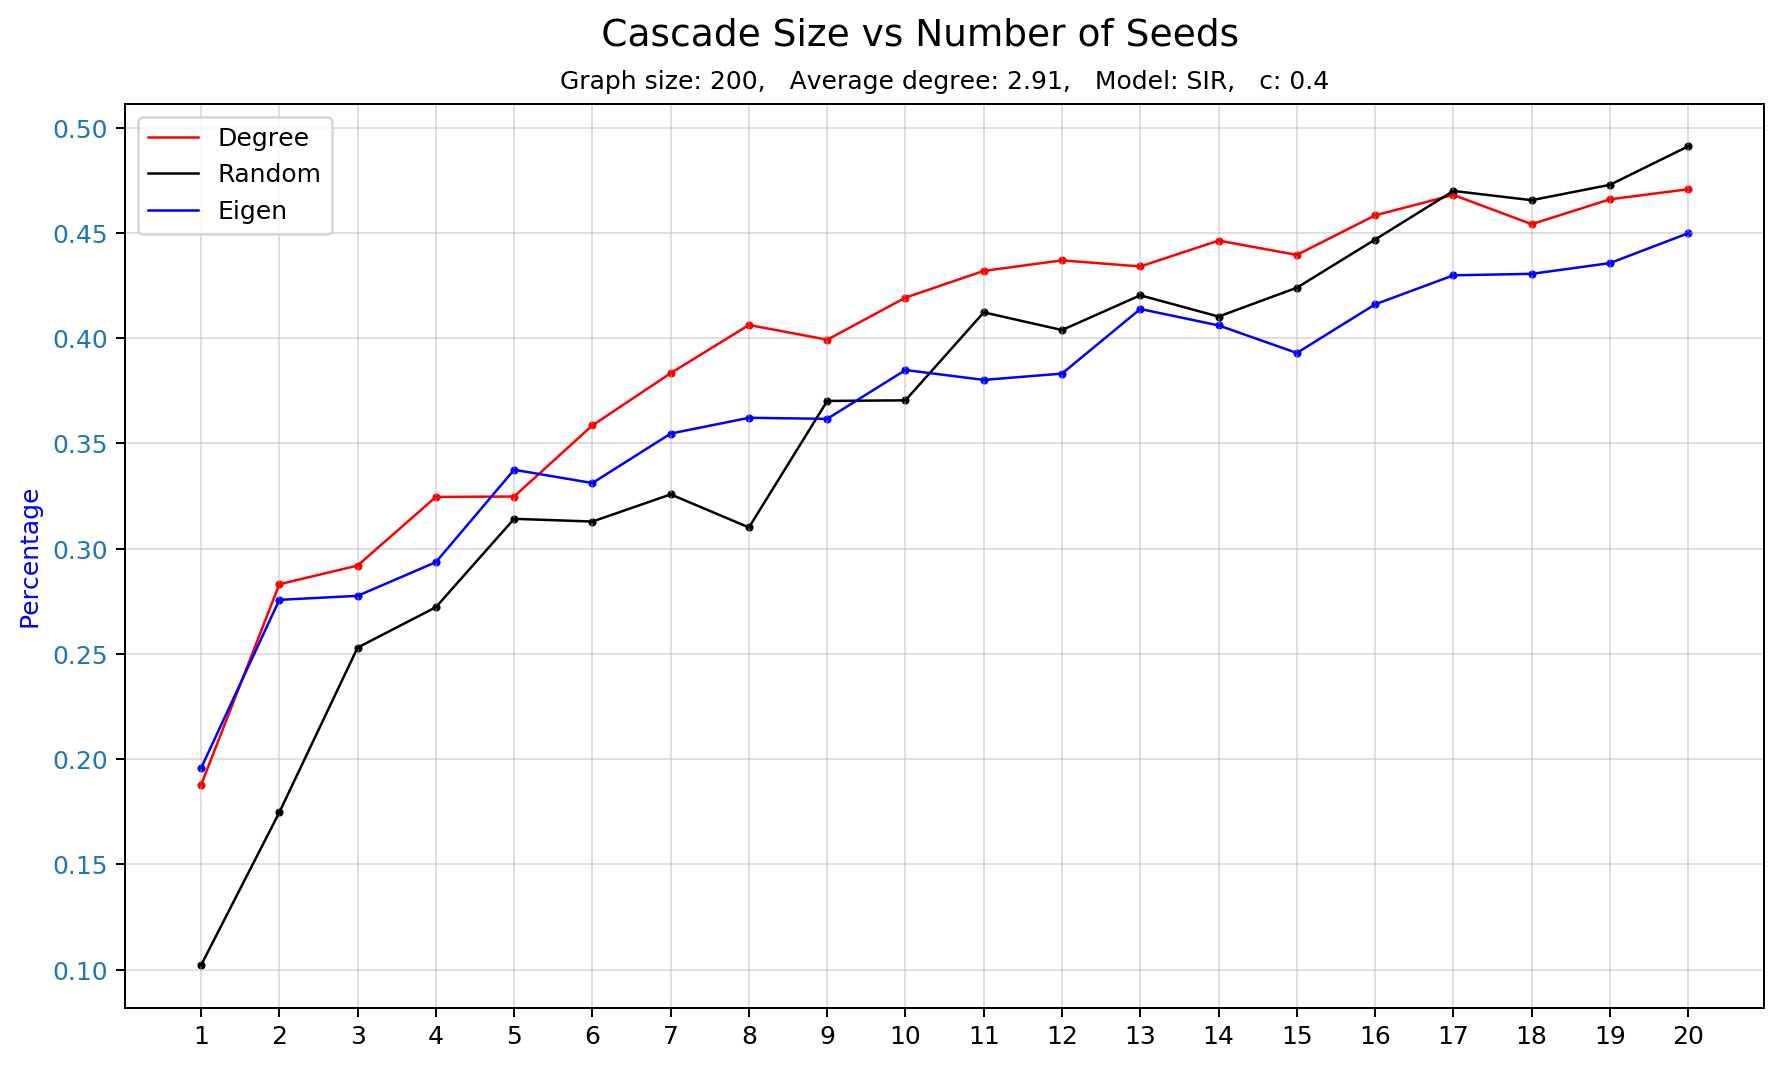

Simulation on the Model "Threshold" with dist_type=4 has started:
Degree  is done!
Random  is done!
Eigen  is done!


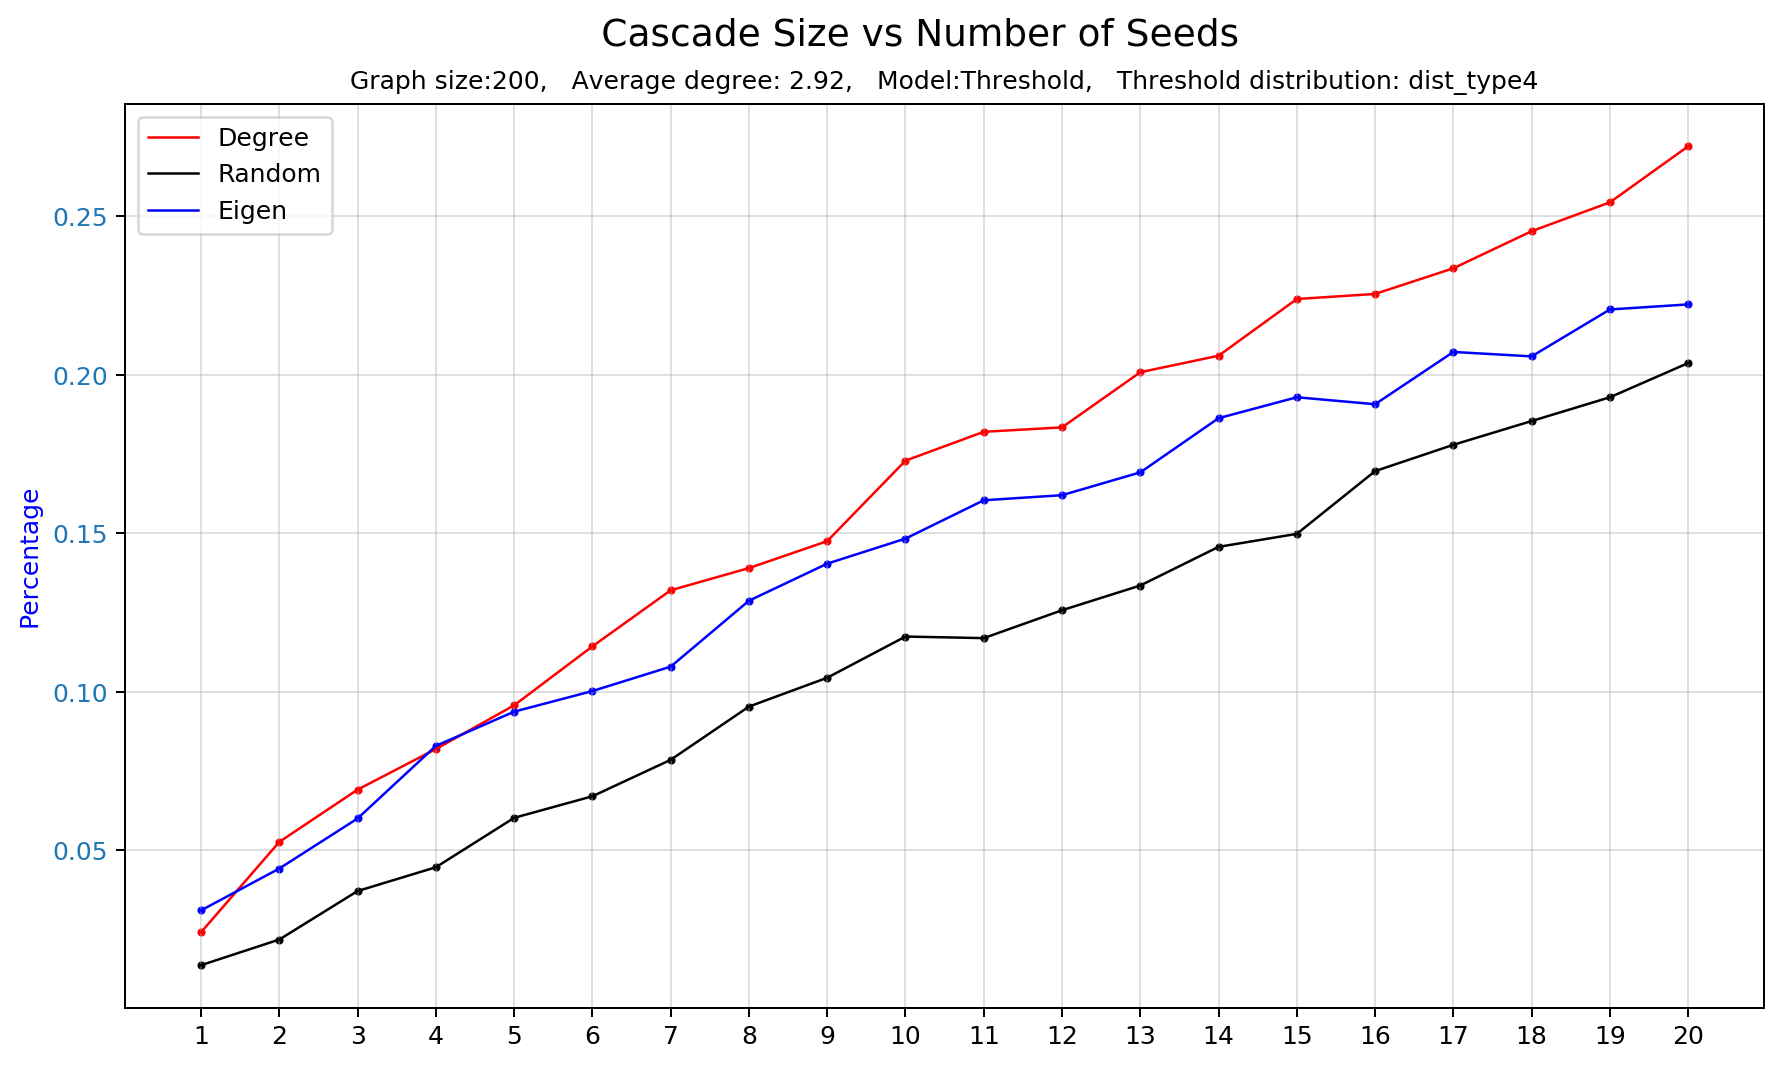

Wall time: 38 s


()

In [93]:
%%time
simulation(Graph=nx.erdos_renyi_graph(200,0.015),method='SIR',c=0.4,plot=['Degree','Random','Eigen'],numSeed=20,Repeat=50)
simulation(Graph=nx.erdos_renyi_graph(200,0.015),method='Threshold',dist_type=4,plot=['Degree','Random','Eigen'],numSeed=20,Repeat=50)